# 01 Data Ingestion and EDA

This notebook implements MVP 1.2 requirements: data overview, univariate distribution checks, treatment-control covariate balance diagnostics, and correlation scan.

## Section 0: Setup

In [5]:
import io
import os
import sys
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from IPython.display import Markdown, display

# Avoid hardcoding the project root path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
# Add project root to sys.path to enable 'from src.xxx import' syntax.
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Change working directory to project root for consistent path resolution
os.chdir(project_root)

from src.data_utils import load_and_clean

# Standardized plotting style
# Improves visual consistency and reviewer readability.
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f'No config file found. Searched: {[str(p) for p in config_candidates]}')

# Load config
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Extract paths and create output directory
raw_data_path = config['paths']['raw_data']
cleaned_data_path = config['paths']['cleaned_data']
raw_text_path = config['paths']['raw_text_data']
figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)

# If you want to overwrite existing output file, set overwrite=True
# df = load_and_clean(filepath=raw_data_path, output_path=cleaned_data_path, raw_text_path=raw_text_path, overwrite=True)
df = load_and_clean(filepath=raw_data_path, output_path=cleaned_data_path, raw_text_path=raw_text_path, overwrite=True)
print(f'Data loaded successfully: shape={df.shape}')


Data loaded successfully: shape=(64000, 13)


Section 0 summary: Config is loaded, cleaning pipeline is executed through `load_and_clean()`, and the dataframe shape confirms data readiness.

## Section 1: 数据概览

In [ ]:
# ---------------------------------
# 1.1 Cleaned data overview
# ---------------------------------
buffer = io.StringIO()
df.info(buf=buffer)
print(buffer.getvalue())

# Normally, df.describe() only includes numeric columns
# 'all': include numeric and object columns
display(df.describe(include='all').transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  object 
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
 12  treatment        64000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 6.3+ MB



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
recency,64000.0,NaN,NaN,NaN,5.763734,3.507592,1.0,2.0,6.0,9.0,12.0
history_segment,64000,7,1) $0 - $100,22970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
history,64000.0,NaN,NaN,NaN,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
mens,64000.0,NaN,NaN,NaN,0.551031,0.497393,0.0,0.0,1.0,1.0,1.0
womens,64000.0,NaN,NaN,NaN,0.549719,0.497526,0.0,0.0,1.0,1.0,1.0
zip_code,64000,3,Surburban,28776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newbie,64000.0,NaN,NaN,NaN,0.50225,0.499999,0.0,0.0,1.0,1.0,1.0
channel,64000,3,Web,28217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
segment,64000,3,Womens E-Mail,21387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit,64000,2,0,54606,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# --------------------------------
#  Missing/NULL value counts
# --------------------------------
# If exists NULL values, load_and_clean_data() did not work properly
missing_stats = df.isnull().sum().sort_values(ascending=False)
display(missing_stats.to_frame('missing_count'))
assert int(missing_stats.sum()) == 0, 'MVP 1.1 cleaning quality issue: null values detected'

,missing_count
recency,0
history_segment,0
history,0
mens,0
womens,0
zip_code,0
newbie,0
channel,0
segment,0
visit,0


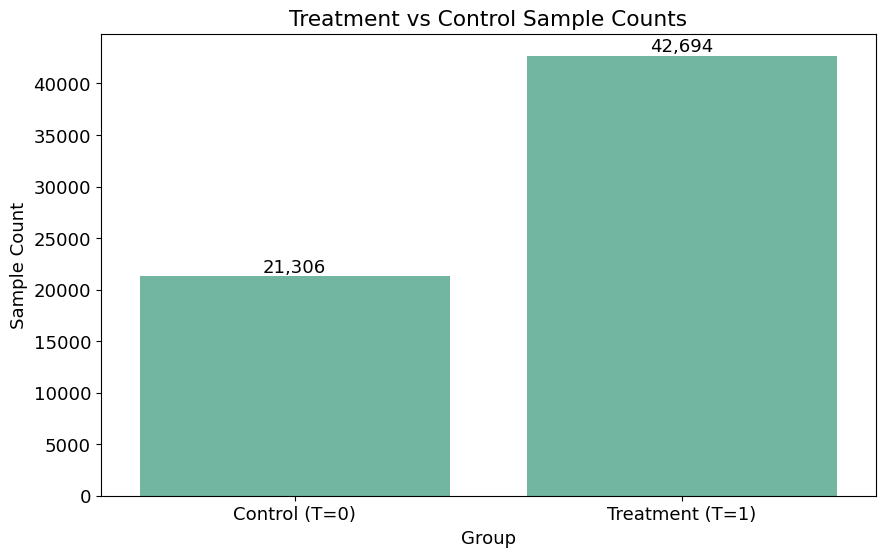

In [ ]:
# -----------------------------------
#  Control/Treatment Sample Counts
# -----------------------------------
group_counts = df['treatment'].value_counts().sort_index()
label_map = {0: 'Control (T=0)', 1: 'Treatment (T=1)'}
plot_df = group_counts.rename(index=label_map).reset_index()
plot_df.columns = ['group', 'count']

ax = sns.barplot(data=plot_df, x='group', y='count')
ax.set_title('Treatment vs Control Sample Counts')
ax.set_xlabel('Group')
ax.set_ylabel('Sample Count')
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}", 
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )
plt.savefig(figures_dir / 'eda_treatment_control_counts.png', dpi=150, bbox_inches='tight')
plt.show()

assert df['treatment'].value_counts().min() > 10000, 'Group sample size too small for robust comparison'

Section 1 summary: Dataset schema and descriptive stats are validated, null checks return all zeros, and treatment/control groups both have sufficient sample sizes for downstream analysis.